<h1>Modélisation : Prédiction des tags algorithmiques</h1>
<h2>Approches Machine Learning </h2>

<hr>

<h2> Objectif de cette section</h2>

<p>
L’objectif de cette section est de concevoir, entraîner et comparer plusieurs modèles
pour la tâche de <strong>classification multi-labels</strong> des exercices d’algorithmique.
</p>

<p>
Nous explorons successivement :
</p>

<ul>
  <li>des modèles classiques de Machine Learning basés sur le texte,</li>
  <li>des approches hybrides combinant texte et features issues du code source,</li>
</ul>


<h2>Sommaire</h2>

<ol>
  <li><a href="#1-preparation-des-donnees">Préparation des données</a></li>
  <li><a href="#2-One-hot-encoding-et-data-splitting">One-hot-encoding et data splitting</a></li>
  <li><a href="#3-vectorisation-tfidf">Vectorisation TF-IDF</a></li>
  <li><a href="#4-modeles-machine-learning">Modèles Machine Learning classiques</a></li>
  <li><a href="#5-optimisation-des-hyperparametres">Optimisation des hyperparamètres</a></li>
  <li><a href="#6-approche-hybride-texte-code">Approche hybride : texte + code source</a></li>
  <li><a href="#7-comparaison-des-performances">Comparaison des performances</a></li>
</ol>

<hr>


### Importations

In [1]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 13.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss, accuracy_score, classification_report,confusion_matrix
from sklearn.svm import LinearSVC, SVC
from google.colab import drive
import zipfile
import os
import json
from glob import glob
import re
import nltk
import contractions
from tqdm.auto import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from scipy.sparse import hstack, csr_matrix
from pathlib import Path
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import random


In [3]:
# -----------------------------
# Fixer la seed globale
# -----------------------------
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

### 1. Préparation des données

<p>
Les données sont chargées à partir de fichiers JSON.
Chaque exercice est associé à :
</p>

<ul>
  <li>une description textuelle nettoyée,</li>
  <li>le code source en Python,</li>
  <li>une liste de tags (multi-label).</li>
</ul>


In [4]:
# Monter Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Chemins (à adapter si besoin)
ZIP_PATH = "/content/drive/MyDrive/code_classification_dataset.zip"
DATASET_DIR = "/content/data"

# Créer le dossier de destination s'il n'existe pas
os.makedirs(DATASET_DIR, exist_ok=True)

# Extraire le zip
with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
    zip_ref.extractall(DATASET_DIR)

print("Fichiers extraits :", len(os.listdir("/content/data/code_classification_dataset")))


Fichiers extraits : 4982


In [6]:
TEXT_FIELDS = [
    "prob_desc_description",
    "prob_desc_input_spec",
    "prob_desc_output_spec",
    "prob_desc_notes",
    "source_code",
    "tags",
]

def load_dataset(dataset_dir):
    records = []
    json_files = glob(os.path.join(dataset_dir, "*.json"))
    print(f"{len(json_files)} fichiers JSON trouvés")

    for path in json_files:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)

        # Créer un nouveau dictionnaire pour chaque fichier JSON
        record = {}
        for field in TEXT_FIELDS:
            record[field] = data.get(field, "") or ""

        # S'assurer que 'tags' est une liste
        if not isinstance(record["tags"], list):
            record["tags"] = []

        records.append(record)

    df = pd.DataFrame(records)

    # Nettoyage supplémentaire
    for field in TEXT_FIELDS:
        df[field] = df[field].fillna("")

    # Forcer l'ordre des colonnes
    df = df[TEXT_FIELDS]

    return df


In [7]:
df = load_dataset("/content/data/code_classification_dataset")

4982 fichiers JSON trouvés


In [8]:
df.describe()

,prob_desc_description,prob_desc_input_spec,prob_desc_output_spec,prob_desc_notes,source_code,tags
count,4982,4982,4982,4982,4982,4982
unique,4982,4928,4822,3597,4982,1907
top,"Alice has a cake, and she is going to cut it. ...",,,,import heapq\r\nimport sys\r\ninput = sys.stdi...,[implementation]
freq,1,33,85,1350,1,273


In [9]:
TARGET_TAGS = [
    'math', 'graphs', 'strings', 'number theory',
    'trees', 'geometry', 'games', 'probabilities'
]

def filter_target_tags(tags):
    return [t for t in tags if t in TARGET_TAGS]

df["tags"] = df["tags"].apply(filter_target_tags)

df = df[df["tags"].map(len) > 0]


In [10]:
df.describe()

,prob_desc_description,prob_desc_input_spec,prob_desc_output_spec,prob_desc_notes,source_code,tags
count,2678,2678,2678,2678,2678,2678
unique,2678,2649,2588,1981,2678,77
top,You are given a string $$$s$$$ consisting of l...,,,,t = int(input())\r\nwhile (t > 0):\r\n t -=...,[math]
freq,1,25,58,678,1,928


In [11]:
df.head(2)

,prob_desc_description,prob_desc_input_spec,prob_desc_output_spec,prob_desc_notes,source_code,tags
0,"You've got an array a, consisting of n integer...",The first line contains two space-separated in...,Print n integers — elements of the array a af...,,"leng, repeat=list(map(int,input().split()))\nL...","[number theory, math]"
1,"You are given $$$n$$$ blocks, each of them is ...",The first line of input contains a single inte...,Print exactly one integer — the maximum total ...,"NoteIn the first example, it is possible to fo...",from random import randint\n\nvalues = [[] for...,[graphs]


In [12]:
# Colonnes à concaténer
cols_to_concat = [
    "prob_desc_description",
    "prob_desc_input_spec",
    "prob_desc_output_spec",
    "prob_desc_notes"
]

# Créer une nouvelle colonne 'description' en concaténant les colonnes avec un espace
df['description'] = df[cols_to_concat].agg(' '.join, axis=1)


In [13]:
df["description"].iloc[0]

"You've got an array a, consisting of n integers. The array elements are indexed from 1 to n. Let's determine a two step operation like that:  First we build by the array a an array s of partial sums, consisting of n elements. Element number i (1\u2009≤\u2009i\u2009≤\u2009n) of array s equals . The operation x\xa0mod\xa0y means that we take the remainder of the division of number x by number y.  Then we write the contents of the array s to the array a. Element number i (1\u2009≤\u2009i\u2009≤\u2009n) of the array s becomes the i-th element of the array a (ai\u2009=\u2009si). You task is to find array a after exactly k described operations are applied. The first line contains two space-separated integers n and k (1\u2009≤\u2009n\u2009≤\u20092000, 0\u2009≤\u2009k\u2009≤\u2009109). The next line contains n space-separated integers a1,\u2009a2,\u2009...,\u2009an\xa0— elements of the array a (0\u2009≤\u2009ai\u2009≤\u2009109). Print n integers \xa0— elements of the array a after the operati

In [14]:
df.head(2)

,prob_desc_description,prob_desc_input_spec,prob_desc_output_spec,prob_desc_notes,source_code,tags,description
0,"You've got an array a, consisting of n integer...",The first line contains two space-separated in...,Print n integers — elements of the array a af...,,"leng, repeat=list(map(int,input().split()))\nL...","[number theory, math]","You've got an array a, consisting of n integer..."
1,"You are given $$$n$$$ blocks, each of them is ...",The first line of input contains a single inte...,Print exactly one integer — the maximum total ...,"NoteIn the first example, it is possible to fo...",from random import randint\n\nvalues = [[] for...,[graphs],"You are given $$$n$$$ blocks, each of them is ..."


In [15]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

class DataProcessor:

    def __init__(self):
        self.stopwords = set(nltk.corpus.stopwords.words("english"))
        # self.lemmatizer = nltk.stem.WordNetLemmatizer()
        self.stemmer = nltk.stem.SnowballStemmer("english")

    def __call__(self, text: str) -> str:

        text = text.lower() # Lowercase
        text = text.replace('-', ' ') # Replace hyphens with spaces
        text = re.sub(r"[^a-zA-Z0-9\s]", " ", text) # Remove special characters
        text = re.sub(r"\s+", " ", text) # Remove extra whitespaces
        text = re.sub(r"\d+", " ", text) # Remove digits
        text = contractions.fix(text) # Expand contractions, for example don't -> do not

        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in self.stopwords]
        # tokens = [self.lemmatizer.lemmatize(word) for word in tokens]
        tokens = [self.stemmer.stem(word) for word in tokens]

        return " ".join(tokens)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [16]:
tqdm.pandas()

In [17]:
processor = DataProcessor()
df['description_clean'] = df['description'].progress_apply(processor)

  0%|          | 0/2678 [00:00<?, ?it/s]

In [18]:
df.head(2)

,prob_desc_description,prob_desc_input_spec,prob_desc_output_spec,prob_desc_notes,source_code,tags,description,description_clean
0,"You've got an array a, consisting of n integer...",The first line contains two space-separated in...,Print n integers — elements of the array a af...,,"leng, repeat=list(map(int,input().split()))\nL...","[number theory, math]","You've got an array a, consisting of n integer...",got array consist n integ array element index ...
1,"You are given $$$n$$$ blocks, each of them is ...",The first line of input contains a single inte...,Print exactly one integer — the maximum total ...,"NoteIn the first example, it is possible to fo...",from random import randint\n\nvalues = [[] for...,[graphs],"You are given $$$n$$$ blocks, each of them is ...",given n block form color valu color block also...


In [19]:
df.iloc[0]["description_clean"]

'got array consist n integ array element index n let determin two step oper like first build array array partial sum consist n element element number n array equal oper x mod mean take remaind divis number x number write content array array element number n array becom th element array ai si task find array exact k describ oper appli first line contain two space separ integ n k n k next line contain n space separ integ element array ai print n integ element array oper appli print element order increas index array separ print number space'

In [20]:
# df = pd.concat(
#     [
#         df[["description_clean", "source_code"]].reset_index(drop=True),
#         pd.DataFrame(
#             y,
#             columns=mlb.classes_
#         )
#     ],
#     axis=1
# )

### 2. One-hot-encoding et data splitting
<p>
Les tags sont binarisés à l’aide d’un <code>MultiLabelBinarizer</code>,
et les données sont séparées en ensembles d’entraînement et de validation (80/20).
</p>

In [21]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["tags"])


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    df["description_clean"].tolist(),
    y,
    test_size=0.2,
    random_state=42
)


### 3. *Vectorisation* TF-IDF

<p>
Le texte des descriptions est vectorisé à l’aide de la méthode <strong>TF-IDF</strong>,
avec les paramètres suivants :
</p>

<ul>
  <li>maximum de 5000 features,</li>
  <li>n-grammes de taille 1 et 2.</li>
</ul>

<p>
Cette représentation permet de capturer à la fois le vocabulaire spécifique
et certaines expressions caractéristiques des problèmes algorithmiques.
</p>


In [23]:
# -----------------------------
# 1. TF-IDF
# -----------------------------
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

### 4. Modèles Machine Learning classiques

<p>
Plusieurs classificateurs de base sont évalués, chacun intégré dans différentes
stratégies multi-label :
</p>

<ul>
  <li><strong>One-vs-Rest (OvR)</strong></li>
  <li><strong>MultiOutputClassifier</strong></li>
  <li><strong>Classifier Chains</strong></li>
</ul>

<p>
Les classificateurs de base testés sont :
</p>

<ul>
  <li>Logistic Regression</li>
  <li>Random Forest</li>
  <li>Support Vector Machines (SVC, LinearSVC)</li>
</ul>

<p>
Les performances sont évaluées à l’aide de métriques adaptées au multi-label,
notamment le <strong>Micro F1-score</strong>, le <strong>Macro F1-score</strong>, le <strong>hamming_loss</strong> et le <strong>subset_accuracy</strong>.
</p>


In [24]:
# -----------------------------
# 2. Définir classificateurs de base
# -----------------------------

base_classifiers = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ),
    "SVC": SVC(
        kernel="linear",
        probability=True,
        class_weight="balanced"
    ),
    "LinearSVC": LinearSVC(
        class_weight="balanced"
    )
}

# -----------------------------
# 3. Définir modèles multi-label
# -----------------------------
models = {}
for name, clf in base_classifiers.items():
    models[f"OVR_{name}"] = OneVsRestClassifier(clf)
    models[f"MultiOutput_{name}"] = MultiOutputClassifier(clf)
    models[f"Chain_{name}"] = ClassifierChain(clf, order='random', random_state=42)
print(models.keys())

dict_keys(['OVR_LogisticRegression', 'MultiOutput_LogisticRegression', 'Chain_LogisticRegression', 'OVR_RandomForest', 'MultiOutput_RandomForest', 'Chain_RandomForest', 'OVR_SVC', 'MultiOutput_SVC', 'Chain_SVC', 'OVR_LinearSVC', 'MultiOutput_LinearSVC', 'Chain_LinearSVC'])


In [25]:
# -----------------------------
# Fonction pour entraîner et prédire
# -----------------------------
def train_and_predict(model, X_train, y_train, X_val):
    """
    Entraîne le modèle et retourne les prédictions sur X_val
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return y_pred

In [26]:
def get_target_names(y_true, mlb=None):
    """
    Retourne les noms des labels pour le classification_report.

    - Si y_true est un DataFrame -> colonnes
    - Si y_true est un ndarray et mlb fourni -> mlb.classes_
    - Sinon -> tag_0, tag_1, ...
    """
    if hasattr(y_true, "columns"):
        return y_true.columns.tolist()
    elif isinstance(y_true, (np.ndarray)) and mlb is not None:
        return mlb.classes_.tolist()
    elif isinstance(y_true, (np.ndarray)):
        return [f"tag_{i}" for i in range(y_true.shape[1])]
    else:
        raise ValueError("Impossible de déterminer les noms des labels. Fournissez y_true ou mlb correctement.")


In [27]:
# -----------------------------
# Fonction pour calculer et afficher les métriques
# -----------------------------
def evaluate_multilabel(y_true, y_pred, mlb=None):
    """
    Calcule et affiche les métriques multi-label et le classification report
    """
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    hamming = hamming_loss(y_true, y_pred)
    subset_acc = accuracy_score(y_true, y_pred)
    prec_micro = precision_score(y_true, y_pred, average='micro')
    rec_micro = recall_score(y_true, y_pred, average='micro')

    print(f"\n✅ Micro F1: {f1_micro:.3f}, Macro F1: {f1_macro:.3f}")
    print(f"Hamming Loss: {hamming:.3f}, Subset Accuracy: {subset_acc:.3f}")
    print(f"Micro Precision: {prec_micro:.3f}, Micro Recall: {rec_micro:.3f}")

    # Récupérer les noms des labels
    target_names = get_target_names(y_true, mlb)

    print("\n - Classification report par tag :")
    print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

    return {
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
        "hamming_loss": hamming,
        "subset_accuracy": subset_acc
    }


In [28]:
# -----------------------------
# Fonction pour sauvegarder le modèle uniquement
# -----------------------------
def save_model(model, save_dir, model_name="best_model.joblib"):
    """
    Sauvegarde le modèle dans le répertoire `save_dir` avec le nom `model_name`.
    Crée le dossier si nécessaire.
    """
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    model_path = save_dir / model_name
    joblib.dump(model, model_path)

    print(f"✅ Modèle sauvegardé ici : {model_path}")
    return model_path


In [29]:
# -----------------------------
# Entraîner et évaluer tous les modèles
# -----------------------------
results_1 = []
trained_models = {}

for model_name, model in models.items():
    # Entraîner et prédire
    print(f"\n🚀 Training {model_name}...")
    y_pred = train_and_predict(model, X_train_tfidf, y_train, X_val_tfidf)

    # Évaluer le modèle et récupérer les métriques
    metrics = evaluate_multilabel(y_val, y_pred, mlb=mlb)

    # Ajouter les métriques au tableau des résultats
    results_1.append({
        "model": model_name,
        "f1_micro": metrics["f1_micro"],
        "f1_macro": metrics["f1_macro"],
        "hamming_loss": metrics["hamming_loss"],
        "subset_accuracy": metrics["subset_accuracy"]
    })

    # Stocker le modèle entraîné
    trained_models[model_name] = model



🚀 Training OVR_LogisticRegression...

✅ Micro F1: 0.716, Macro F1: 0.667
Hamming Loss: 0.098, Subset Accuracy: 0.448
Micro Precision: 0.664, Micro Recall: 0.777

 - Classification report par tag :
               precision    recall  f1-score   support

        games       0.75      0.81      0.78        26
     geometry       0.55      0.76      0.64        34
       graphs       0.55      0.76      0.64       105
         math       0.79      0.81      0.80       276
number theory       0.50      0.65      0.57        79
probabilities       0.47      0.39      0.42        18
      strings       0.82      0.89      0.85        85
        trees       0.53      0.78      0.63        59

    micro avg       0.66      0.78      0.72       682
    macro avg       0.62      0.73      0.67       682
 weighted avg       0.68      0.78      0.72       682
  samples avg       0.69      0.80      0.71       682


🚀 Training MultiOutput_LogisticRegression...

✅ Micro F1: 0.716, Macro F1: 0.667
Ha

In [30]:
# -----------------------------
# 5. Résultats triés par Macro F1
# -----------------------------
results_df_1 = pd.DataFrame(results_1).sort_values(by='f1_macro', ascending=False)
print("\n=== Résultats finaux triés par Macro F1 ===")
results_df_1



=== Résultats finaux triés par Macro F1 ===


,model,f1_micro,f1_macro,hamming_loss,subset_accuracy
11,Chain_LinearSVC,0.736766,0.710432,0.084655,0.541045
9,OVR_LinearSVC,0.742733,0.709555,0.082556,0.524254
10,MultiOutput_LinearSVC,0.742733,0.709555,0.082556,0.524254
8,Chain_SVC,0.702203,0.680710,0.097715,0.485075
6,OVR_SVC,0.713990,0.676267,0.096782,0.442164
7,MultiOutput_SVC,0.713990,0.676267,0.096782,0.442164
1,MultiOutput_LogisticRegression,0.716216,0.666752,0.097948,0.447761
0,OVR_LogisticRegression,0.716216,0.666752,0.097948,0.447761
5,Chain_RandomForest,0.736000,0.654981,0.076959,0.559701
3,OVR_RandomForest,0.727124,0.654978,0.077892,0.546642


In [31]:
# -----------------------------
# Identifier le meilleur modèle (Macro F1)
# -----------------------------
best_model_info_1 = results_df_1.iloc[0]           # première ligne = meilleur modèle
best_model_name_1 = best_model_info_1["model"]    # nom du modèle
best_model_1 = models[best_model_name_1]          # récupérer l'objet modèle

print(f"\n🏆 Meilleur modèle : {best_model_name_1}")
print(f"Macro F1 : {best_model_info_1['f1_macro']:.3f}, Micro F1 : {best_model_info_1['f1_micro']:.3f}")

print("Hyperparamètres du meilleur modèle :")
best_params_1 = best_model_1.get_params()
print(best_params_1)


🏆 Meilleur modèle : Chain_LinearSVC
Macro F1 : 0.710, Micro F1 : 0.737
Hyperparamètres du meilleur modèle :
{'base_estimator__C': 1.0, 'base_estimator__class_weight': 'balanced', 'base_estimator__dual': 'auto', 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__loss': 'squared_hinge', 'base_estimator__max_iter': 1000, 'base_estimator__multi_class': 'ovr', 'base_estimator__penalty': 'l2', 'base_estimator__random_state': None, 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator': LinearSVC(class_weight='balanced'), 'chain_method': 'predict', 'cv': None, 'order': 'random', 'random_state': 42, 'verbose': False}


In [32]:
# -----------------------------
# Sauvegarder le modèle
# -----------------------------
save_dir_1 = Path("/content/drive/MyDrive/codeforces_classifier/best_classifier")
save_model(best_model_1, save_dir_1,best_model_name_1)


✅ Modèle sauvegardé ici : /content/drive/MyDrive/codeforces_classifier/best_classifier/Chain_LinearSVC


PosixPath('/content/drive/MyDrive/codeforces_classifier/best_classifier/Chain_LinearSVC')

### 5. Optimisation des hyperparamètres

<p>
Une recherche par grille (<code>GridSearchCV</code>) est réalisée
sur le modèle le plus performant afin d’optimiser les hyperparamètres,
en utilisant le <strong>Micro F1-score</strong> comme métrique principale.
</p>

<p>
Cette étape permet d’améliorer la généralisation du modèle
tout en prenant en compte le déséquilibre entre les classes.
</p>


In [33]:
base_model = OneVsRestClassifier(
    LinearSVC(class_weight="balanced", random_state=42)
)


param_grid = {
    "estimator__C": [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    "estimator__loss": ["hinge", "squared_hinge"],
    "estimator__max_iter": [1000, 3000],
    "estimator__tol": [1e-4, 1e-3]
}


grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring="f1_micro",
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_tfidf, y_train)
print("✅ Meilleurs paramètres :")
best_params = grid_search.best_params_
print(best_params)

print("\n✅ Meilleur score CV (F1 micro) :")
print(grid_search.best_score_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
✅ Meilleurs paramètres :
{'estimator__C': 0.1, 'estimator__loss': 'squared_hinge', 'estimator__max_iter': 1000, 'estimator__tol': 0.0001}

✅ Meilleur score CV (F1 micro) :
0.7027352877002406


In [34]:
best_model_2 = grid_search.best_estimator_

y_pred = best_model_2.predict(X_val_tfidf)

# Évaluer le modèle et récupérer les métriques
metrics_2 = evaluate_multilabel(y_val, y_pred, mlb=mlb)


✅ Micro F1: 0.714, Macro F1: 0.666
Hamming Loss: 0.099, Subset Accuracy: 0.446
Micro Precision: 0.661, Micro Recall: 0.776

 - Classification report par tag :
               precision    recall  f1-score   support

        games       0.72      0.81      0.76        26
     geometry       0.58      0.76      0.66        34
       graphs       0.55      0.76      0.64       105
         math       0.79      0.81      0.80       276
number theory       0.49      0.65      0.56        79
probabilities       0.50      0.39      0.44        18
      strings       0.82      0.88      0.85        85
        trees       0.53      0.78      0.63        59

    micro avg       0.66      0.78      0.71       682
    macro avg       0.62      0.73      0.67       682
 weighted avg       0.68      0.78      0.72       682
  samples avg       0.69      0.80      0.71       682



In [35]:
# -----------------------------
# Sauvegarder le modèle
# -----------------------------
save_dir_2 = Path("/content/drive/MyDrive/codeforces_classifier/grid_search")

save_model(best_model_2, save_dir_2, model_name="best_grid_search_ovr_linear_svc.joblib")



✅ Modèle sauvegardé ici : /content/drive/MyDrive/codeforces_classifier/grid_search/best_grid_search_ovr_linear_svc.joblib


PosixPath('/content/drive/MyDrive/codeforces_classifier/grid_search/best_grid_search_ovr_linear_svc.joblib')

In [36]:
best_params

{'estimator__C': 0.1,
 'estimator__loss': 'squared_hinge',
 'estimator__max_iter': 1000,
 'estimator__tol': 0.0001}

In [37]:
# -----------------------------
# Fonction principale : pipeline OVR_LinearSVC
# -----------------------------
def run_ovr_linear_svc_pipeline(X_train, y_train, X_val, y_val, best_params, save_dir, model_name="best_ovr_linear_svc.joblib", mlb=None):
    """
    Entraîne un OneVsRest LinearSVC avec les meilleurs hyperparamètres,
    évalue les métriques multi-label et sauvegarde le modèle.

    Arguments :
        X_train, y_train : données d'entraînement
        X_val, y_val : données de validation
        best_params : dict des meilleurs hyperparamètres pour LinearSVC
        save_dir : répertoire pour sauvegarder le modèle
        model_name : nom du fichier sauvegardé
        mlb : MultiLabelBinarizer, optionnel si y_val est ndarray

    Retourne :
        best_model : modèle entraîné
        metrics : dict des métriques
    """
    # Si les clés contiennent 'estimator__', on les retire
    clean_params = {k.replace("estimator__", ""): v for k, v in best_params.items()}

    # Créer le modèle
    best_model = OneVsRestClassifier(
        LinearSVC(class_weight="balanced", **clean_params)
    )

    # Entraîner et prédire
    print(f"\n🚀 Training OVR_LinearSVC with params: {best_params}")
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_val)

    # Évaluer
    metrics = evaluate_multilabel(y_val, y_pred, mlb)

    # Sauvegarder le modèle
    save_dir = Path(save_dir)
    save_model(best_model,save_dir, model_name)

    return best_model, metrics

### 6. Approche hybride : texte + code source

<p>
En complément du texte, des features binaires sont extraites
directement du code source afin de capturer des indices algorithmiques explicites :
</p>

<ul>
  <li>présence de DFS/BFS,</li>
  <li>utilisation du modulo ou de la récursion,</li>
  <li>structures de graphes ou d’arbres,</li>
  <li>éléments liés aux probabilités ou aux jeux.</li>
</ul>

<p>
Les features issues du code sont concaténées aux vecteurs TF-IDF
afin de former une représentation hybride plus expressive.
</p>


In [38]:
# def extract_code_features(code):
#     """
#     Extraire des features pertinentes pour prédire les tags algorithmique.
#     """
#     features = {}

#     # -----------------------------
#     # 1️⃣ Structures mathématiques
#     # -----------------------------
#     features['has_mod'] = int('%' in code)                    # modulo
#     features['has_pow'] = int('**' in code or 'pow(' in code) # exponentiation
#     features['has_factorial'] = int('fact' in code)           # factorielle
#     features['has_comb'] = int('comb' in code)                # combinaisons
#     features['has_math_import'] = int('import math' in code)

#     # -----------------------------
#     # Graphes / parcours
#     # -----------------------------
#     features['has_dfs'] = int('dfs' in code.lower())          # DFS
#     features['has_bfs'] = int('bfs' in code.lower())          # BFS
#     features['has_edges'] = int('edges' in code.lower())
#     features['has_adj'] = int('adj' in code.lower())          # adjacency
#     features['has_graph_list'] = int('graph' in code.lower())

#     # -----------------------------
#     # Récursion / structures arborescentes
#     # -----------------------------
#     features['has_recursion'] = int('def' in code and code.count('def') > 1)
#     features['has_tree'] = int('tree' in code.lower())

#     # -----------------------------
#     # Chaînes et manipulation de strings
#     # -----------------------------
#     features['has_string'] = int('str(' in code or '"' in code or "'" in code)
#     # features['has_split'] = int('.split(' in code)
#     features['has_join'] = int('.join(' in code)

#     # -----------------------------
#     # Jeux / probabilités
#     # -----------------------------
#     features['has_random'] = int('random' in code)           # tirage aléatoire
#     features['has_probability'] = int('prob' in code.lower() or 'chance' in code.lower())

#     # -----------------------------
#     # Boucles / itérations
#     # -----------------------------
#     # features['has_for'] = int('for ' in code)
#     features['has_while'] = int('while ' in code)
#     # features['has_nested_loops'] = int(code.count('for ') + code.count('while ') > 1)

#     # -----------------------------
#     # Listes / tableaux
#     # -----------------------------
#     # features['has_list'] = int('[' in code and ']' in code)
#     features['has_append'] = int('.append(' in code)

#     return list(features.values())


In [39]:
import re

def extract_code_features(code: str):
    code_l = code.lower()
    features = {}

    # =====================================================
    # MATH / NUMBER THEORY
    # =====================================================
    features["has_mod"] = int("%" in code)
    features["has_pow"] = int("**" in code or "pow(" in code)
    features["has_gcd"] = int("gcd" in code_l)
    features["has_lcm"] = int("lcm" in code_l)
    features["has_prime"] = int("prime" in code_l)
    features["has_factorial"] = int("fact" in code_l)
    features["has_math_import"] = int("import math" in code_l)
    features["has_bit_ops"] = int(any(op in code for op in ["<<", ">>", "&", "|", "^"]))

    # =====================================================
    # GRAPHS
    # =====================================================
    features["has_dfs"] = int("dfs" in code_l)
    features["has_bfs"] = int("bfs" in code_l)
    features["has_adj_list"] = int("adj" in code_l or "neighbors" in code_l)
    features["has_edges"] = int("edges" in code_l)
    features["has_queue"] = int("deque" in code_l or "queue" in code_l)
    features["has_stack"] = int("stack" in code_l)
    features["has_visited"] = int("visited" in code_l)

    # =====================================================
    # TREES
    # =====================================================
    features["has_tree"] = int("tree" in code_l)
    features["has_node"] = int("node" in code_l)
    features["has_left_right"] = int("left" in code_l and "right" in code_l)
    features["has_recursion"] = int(code.count("def") > 1)
    features["has_depth"] = int("depth" in code_l or "height" in code_l)

    # =====================================================
    # STRINGS
    # =====================================================
    features["has_string_literal"] = int(bool(re.search(r"['\"]", code)))
    features["has_split"] = int(".split(" in code)
    features["has_join"] = int(".join(" in code)
    features["has_replace"] = int(".replace(" in code)
    features["has_substring"] = int("substr" in code_l or "substring" in code_l)
    features["has_ord_chr"] = int("ord(" in code or "chr(" in code)

    # =====================================================
    # PROBABILITIES
    # =====================================================
    features["has_probability"] = int("prob" in code_l or "chance" in code_l)
    features["has_fraction"] = int("fraction" in code_l)
    features["has_float_div"] = int("/" in code and "//" not in code)
    features["has_expectation"] = int("expect" in code_l)

    # =====================================================
    # GAMES
    # =====================================================
    features["has_random"] = int("random" in code_l)
    features["has_turn"] = int("turn" in code_l)
    features["has_player"] = int("player" in code_l)
    features["has_score"] = int("score" in code_l)
    features["has_game_dp"] = int("dp" in code_l and ("win" in code_l or "lose" in code_l))

    # =====================================================
    # GEOMETRY
    # =====================================================
    features["has_point"] = int("point" in code_l)
    features["has_distance"] = int("dist" in code_l)
    features["has_angle"] = int("angle" in code_l)
    features["has_cross_product"] = int("cross" in code_l)
    features["has_dot_product"] = int("dot" in code_l)
    features["has_hypot"] = int("hypot" in code_l)

    return list(features.values())


In [40]:
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [41]:
# -----------------------------
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["tags"])


# -----------------------------
# Split train/val
# -----------------------------
X_train_text, X_val_text, y_train, y_val, train_idx, val_idx = train_test_split(
    df["description_clean"].tolist(),
    y,
    np.arange(len(df)),  # indices positionnels
    test_size=0.2,
    random_state=42
)

In [42]:
# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_val_tfidf   = vectorizer.transform(X_val_text)

# Extraire features code
X_train_code_features = np.array([extract_code_features(c) for c in df.iloc[train_idx]["source_code"]])
X_val_code_features   = np.array([extract_code_features(c) for c in df.iloc[val_idx]["source_code"]])

# Convertir en sparse matrix
X_train_code_sparse = csr_matrix(X_train_code_features)
X_val_code_sparse   = csr_matrix(X_val_code_features)

# Combiner TF-IDF + code features
X_train_combined = hstack([X_train_tfidf, X_train_code_sparse])
X_val_combined   = hstack([X_val_tfidf, X_val_code_sparse])

print("✅ Shape X_train_combined :", X_train_combined.shape)
print("✅ Shape X_val_combined   :", X_val_combined.shape)


✅ Shape X_train_combined : (2142, 5041)
✅ Shape X_val_combined   : (536, 5041)


In [43]:
save_dir_3 = "/content/drive/MyDrive/codeforces_classifier/code_source"

best_model_3, metrics_3 = run_ovr_linear_svc_pipeline(
    X_train_combined,
    y_train,
    X_val_combined,
    y_val,
    best_params,
    save_dir_3,
    model_name="best_grid_search_ovr_linear_svc.joblib",
    mlb=mlb
)



🚀 Training OVR_LinearSVC with params: {'estimator__C': 0.1, 'estimator__loss': 'squared_hinge', 'estimator__max_iter': 1000, 'estimator__tol': 0.0001}

✅ Micro F1: 0.743, Macro F1: 0.697
Hamming Loss: 0.090, Subset Accuracy: 0.493
Micro Precision: 0.682, Micro Recall: 0.815

 - Classification report par tag :
               precision    recall  f1-score   support

        games       0.73      0.85      0.79        26
     geometry       0.52      0.74      0.61        34
       graphs       0.57      0.80      0.67       105
         math       0.80      0.84      0.82       276
number theory       0.59      0.72      0.65        79
probabilities       0.41      0.67      0.51        18
      strings       0.82      0.89      0.85        85
        trees       0.58      0.81      0.68        59

    micro avg       0.68      0.82      0.74       682
    macro avg       0.63      0.79      0.70       682
 weighted avg       0.70      0.82      0.75       682
  samples avg       0.72  

### SMOTE

In [44]:
df.head(2)

,prob_desc_description,prob_desc_input_spec,prob_desc_output_spec,prob_desc_notes,source_code,tags,description,description_clean
0,"You've got an array a, consisting of n integer...",The first line contains two space-separated in...,Print n integers — elements of the array a af...,,"leng, repeat=list(map(int,input().split()))\nL...","[number theory, math]","You've got an array a, consisting of n integer...",got array consist n integ array element index ...
1,"You are given $$$n$$$ blocks, each of them is ...",The first line of input contains a single inte...,Print exactly one integer — the maximum total ...,"NoteIn the first example, it is possible to fo...",from random import randint\n\nvalues = [[] for...,[graphs],"You are given $$$n$$$ blocks, each of them is ...",given n block form color valu color block also...


In [45]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["tags"])


In [46]:
dtrain = pd.concat(
    [
        df[["description_clean"]].reset_index(drop=True),
        pd.DataFrame(
            y,
            columns=mlb.classes_
        )
    ],
    axis=1
)

In [47]:
dtrain.head(1)

,description_clean,games,geometry,graphs,math,number theory,probabilities,strings,trees
0,got array consist n integ array element index ...,0,0,0,1,1,0,0,0


In [48]:
# X = dtrain['description_clean']
y = dtrain[TARGET_TAGS]

In [49]:
y

,math,graphs,strings,number theory,trees,geometry,games,probabilities
0,1,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
2673,0,0,1,0,0,0,0,0
2674,1,0,0,1,0,0,0,0
2675,0,1,0,0,0,0,0,1
2676,1,1,0,1,0,0,0,0


In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(dtrain['description_clean'])

In [51]:
X.shape

(2678, 5000)

In [52]:
# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
def irpl(y : pd.DataFrame) -> pd.Series:
    labels_count = y.sum(axis=0)
    return labels_count.max() / labels_count

In [54]:
irpls = irpl(y_train)
print(irpls)

math              1.000000
graphs            2.590389
strings           3.359050
number theory     4.177122
trees             4.271698
geometry          8.575758
games            14.329114
probabilities    15.297297
dtype: float64


In [55]:
tail_labels = irpls.index[irpls > irpls.mean()]
print(tail_labels)

Index(['geometry', 'games', 'probabilities'], dtype='object')


In [56]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

class MLSMOTE:

    def __init__(self,
        n_neighbors : int = 5,
        alpha_scale : float = 0.25,
    ) -> None:

        self.irpls = None
        self.tail_labels = None
        self.nn = None
        self.labels_count = None

        self.n_neighbors = n_neighbors
        self.alpha_scale = alpha_scale

    def _irpl(self, y : pd.DataFrame) -> pd.Series:
        labels_count = y.sum(axis=0)
        return labels_count.max() / labels_count

    def _tail_labels(self, y : pd.DataFrame) -> list[str]:
        irpls = self._irpl(y)
        return irpls.index[irpls > irpls.mean()].to_list()

    def _labels_count(self) -> dict:

        irpls = self.irpls
        p = irpls / irpls.sum()
        p = p ** -self.alpha_scale
        p = p / p.sum()
        p = p * len(y)
        p = p.astype(int)
        p = p[self.tail_labels].to_dict()

        return p

    def fit_resample(self, X : pd.DataFrame, y : pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:

        ### Compute the IRPL for each label
        irpls = self._irpl(y)
        self.irpls = irpls

        ### Get the tail labels
        tail_labels = self._tail_labels(y)
        self.tail_labels = tail_labels

        ### Calculate the number of synthetic samples to generate for each tail label
        labels_count = self._labels_count()
        self.labels_count = labels_count

        ### Restrict X and y to instances with tail labels
        index = X.index[y[tail_labels].sum(axis=1) > 0]
        subset_X = X.loc[index].reset_index(drop=True)
        subset_y = y.loc[index].reset_index(drop=True)

        ### Get the neighbors for each sample in the subset
        nn = NearestNeighbors(n_neighbors=self.n_neighbors)
        self.nn = nn.fit(X)
        neighbors = nn.kneighbors(subset_X, return_distance=False)

        ### Generate synthetic samples
        X_synth = [X]
        y_synth = [y]

        for tail_label, count in labels_count.items():

            # 1- Pick random reference samples
            indices = np.arange(len(subset_X))
            indices = indices[subset_y[tail_label] == 1]
            reference_indices = np.random.choice(indices, count)

            # 2- Pick random neighbors of the reference samples
            random_neighbors = np.random.randint(1, self.n_neighbors, count)
            random_neighbors = neighbors[reference_indices, random_neighbors]

            # 3- Compute the difference between the reference samples and their neighbors
            gap = subset_X.iloc[reference_indices].values - X.iloc[random_neighbors].values

            # 4- Compute the synthetic samples features X
            ratio = np.random.rand(count, 1)
            X_new = subset_X.loc[reference_indices].values + ratio * gap
            X_new = pd.DataFrame(X_new, columns=subset_X.columns)

            # 5- Compute the synthetic samples labels y
            y_new = y.values[neighbors[reference_indices,:].flatten()]
            y_new = y_new.reshape(count, self.n_neighbors, subset_y.shape[1])
            y_new = y_new.sum(axis=1) > 0
            y_new = y_new.astype(int)
            y_new = pd.DataFrame(y_new, columns=subset_y.columns)

            # 6- Append the synthetic samples to the original dataset
            X_synth.append(X_new)
            y_synth.append(y_new)

        X_synth = pd.concat(X_synth)
        y_synth = pd.concat(y_synth)

        return X_synth, y_synth

In [57]:
mlsmote = MLSMOTE(alpha_scale=0.1)

X_train_dense = X_train.toarray()  # Convert sparse to dense
X_train_resampled, y_train_resampled = mlsmote.fit_resample(pd.DataFrame(X_train_dense, index=y_train.index), y_train)


In [58]:
X_val_dense = X_val.toarray()

In [59]:
irpls = irpl(y_train_resampled)
print(irpls)

math             1.000000
graphs           1.620496
strings          4.261053
number theory    5.009901
trees            4.225470
geometry         4.190476
games            4.784870
probabilities    5.203085
dtype: float64


In [60]:
save_dir_4 = "/content/drive/MyDrive/codeforces_classifier/smote_model"

best_model_4, metrics_4 = run_ovr_linear_svc_pipeline(
    X_train_resampled,
    y_train_resampled,
    X_val_dense,
    y_val,
    best_params,
    save_dir_4,
    model_name="ovr_linear_svc.joblib",
)



🚀 Training OVR_LinearSVC with params: {'estimator__C': 0.1, 'estimator__loss': 'squared_hinge', 'estimator__max_iter': 1000, 'estimator__tol': 0.0001}

✅ Micro F1: 0.694, Macro F1: 0.652
Hamming Loss: 0.103, Subset Accuracy: 0.431
Micro Precision: 0.658, Micro Recall: 0.735

 - Classification report par tag :
               precision    recall  f1-score   support

         math       0.78      0.80      0.79       276
       graphs       0.48      0.59      0.53       105
      strings       0.79      0.88      0.83        85
number theory       0.46      0.63      0.53        79
        trees       0.53      0.80      0.64        59
     geometry       0.70      0.62      0.66        34
        games       0.83      0.77      0.80        26
probabilities       1.00      0.28      0.43        18

    micro avg       0.66      0.73      0.69       682
    macro avg       0.70      0.67      0.65       682
 weighted avg       0.68      0.73      0.70       682
  samples avg       0.65  

### <h2 id="7-comparaison-des-performances">7. Comparaison des performances</h2>

<p>
Les modèles sont comparés selon plusieurs critères :
</p>

<ul>
  <li>Micro F1-score (performance globale),</li>
  <li>Macro F1-score (équité entre les tags),</li>
  <li>Hamming Loss,</li>
  <li>Performances par tag.</li>
</ul>

<p>
Cette analyse permet d’identifier les forces et limites de chaque approche,
ainsi que les tags les mieux prédits.
</p>


In [61]:
def train_evaluate_model(X_train, y_train, X_val, y_val, best_params, mlb=None):
    """
    Entraîne OVR_LinearSVC et retourne les métriques et prédictions.
    """
    # Nettoyer params si GridSearch
    clean_params = {k.replace("estimator__", ""): v for k, v in best_params.items()}

    model = OneVsRestClassifier(LinearSVC(class_weight="balanced", **clean_params))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    metrics = evaluate_multilabel(y_val, y_pred, mlb)

    return model, y_pred, metrics


In [62]:
def prepare_dataset(df, text_column="description_clean", code_column=None, tags_column="tags",
                    tfidf_max_features=5000, tfidf_ngram_range=(1,2), test_size=0.2, random_state=42):
    """
    Prépare les données pour le multi-label classification.
    """
    # -----------------------------
    # Binarisation des tags
    # -----------------------------
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(df[tags_column])

    # -----------------------------
    # Split train/val
    # -----------------------------
    train_idx, val_idx = train_test_split(np.arange(len(df)), test_size=test_size, random_state=random_state)
    X_train_text = [df.iloc[i][text_column] for i in train_idx]
    X_val_text   = [df.iloc[i][text_column] for i in val_idx]
    y_train = y[train_idx]
    y_val   = y[val_idx]

    # -----------------------------
    # TF-IDF sur le texte
    # -----------------------------
    vectorizer = TfidfVectorizer(max_features=tfidf_max_features, ngram_range=tfidf_ngram_range)
    X_train_tfidf = vectorizer.fit_transform(X_train_text)
    X_val_tfidf   = vectorizer.transform(X_val_text)

    # -----------------------------
    # Option : features du code source
    # -----------------------------
    if code_column is not None:
        X_train_code_features = np.array([extract_code_features(df.iloc[i][code_column]) for i in train_idx])
        X_val_code_features   = np.array([extract_code_features(df.iloc[i][code_column]) for i in val_idx])

        X_train_code_sparse = csr_matrix(X_train_code_features)
        X_val_code_sparse   = csr_matrix(X_val_code_features)

        # Combiner TF-IDF + features code
        X_train_combined = hstack([X_train_tfidf, X_train_code_sparse])
        X_val_combined   = hstack([X_val_tfidf, X_val_code_sparse])
    else:
        X_train_combined = X_train_tfidf
        X_val_combined   = X_val_tfidf

    print("✅ Shape X_train_tfidf :", X_train_tfidf.shape)
    print("✅ Shape X_val_tfidf   :", X_val_tfidf.shape)
    print("✅ Shape X_train_combined :", X_train_combined.shape)
    print("✅ Shape X_val_combined   :", X_val_combined.shape)

    return X_train_tfidf, X_val_tfidf, X_train_combined, X_val_combined, y_train, y_val, mlb, train_idx, val_idx


In [63]:
# Préparation des données (TF-IDF seul + TF-IDF + features code)
X_train_tfidf, X_val_tfidf, X_train_combined, X_val_combined, y_train, y_val, mlb, train_idx, val_idx = prepare_dataset(
    df,
    text_column="description_clean",
    code_column="source_code",  # None si pas de features code
    tags_column="tags",
    tfidf_max_features=5000,
    tfidf_ngram_range=(1,2),
    test_size=0.2,
    random_state=42
)


✅ Shape X_train_tfidf : (2142, 5000)
✅ Shape X_val_tfidf   : (536, 5000)
✅ Shape X_train_combined : (2142, 5041)
✅ Shape X_val_combined   : (536, 5041)


In [64]:
y_df = pd.DataFrame(y_train, columns=mlb.classes_)

mlsmote = MLSMOTE(alpha_scale=0.1)

# Convertir X_train en dense si nécessaire
X_train_dense = X_train_tfidf.toarray()  # TF-IDF seul

# Resample
X_train_resampled, y_train_resampled = mlsmote.fit_resample(
    pd.DataFrame(X_train_dense),
    y_df  # DataFrame avec colonnes = noms des tags
)

# Conversion pour validation
X_val_dense = X_val_tfidf.toarray() if not isinstance(X_val_tfidf, np.ndarray) else X_val_tfidf

In [65]:
results_comparison = []

# Modèle avec seulement les descriptions
model_desc, y_pred_desc, metrics_desc = train_evaluate_model(
    X_train_tfidf, y_train, X_val_tfidf, y_val, best_params, mlb
)
results_comparison.append({"approach": "Descriptions only", **metrics_desc})

# Modèle avec description + features du code source
model_combined, y_pred_combined, metrics_combined = train_evaluate_model(
    X_train_combined, y_train, X_val_combined, y_val, best_params, mlb
)
results_comparison.append({"approach": "Descriptions + code features", **metrics_combined})

# Modèle avec SMOTE / resampling
model_smote, y_pred_smote, metrics_smote = train_evaluate_model(
    X_train_resampled, y_train_resampled, X_val_dense, y_val, best_params, mlb
)
results_comparison.append({"approach": "Resampled (SMOTE)", **metrics_smote})



✅ Micro F1: 0.714, Macro F1: 0.666
Hamming Loss: 0.099, Subset Accuracy: 0.446
Micro Precision: 0.661, Micro Recall: 0.776

 - Classification report par tag :
               precision    recall  f1-score   support

        games       0.72      0.81      0.76        26
     geometry       0.58      0.76      0.66        34
       graphs       0.55      0.76      0.64       105
         math       0.79      0.81      0.80       276
number theory       0.49      0.65      0.56        79
probabilities       0.50      0.39      0.44        18
      strings       0.82      0.88      0.85        85
        trees       0.53      0.78      0.63        59

    micro avg       0.66      0.78      0.71       682
    macro avg       0.62      0.73      0.67       682
 weighted avg       0.68      0.78      0.72       682
  samples avg       0.69      0.80      0.71       682


✅ Micro F1: 0.743, Macro F1: 0.697
Hamming Loss: 0.090, Subset Accuracy: 0.493
Micro Precision: 0.682, Micro Recall: 0.81

In [66]:
results_df = pd.DataFrame(results_comparison).set_index("approach")

# Trier par f1_macro décroissant
results_df = results_df.sort_values(by="f1_macro", ascending=False)

print("\n=== Comparaison des approches triée par Macro F1 ===")
display(results_df)



=== Comparaison des approches triée par Macro F1 ===


,f1_micro,f1_macro,hamming_loss,subset_accuracy
approach,,,,
Descriptions + code features,0.742819,0.696929,0.089785,0.492537
Resampled (SMOTE),0.697799,0.667017,0.105644,0.421642
Descriptions only,0.713900,0.666346,0.098881,0.445896


In [67]:
def plot_results(results: pd.DataFrame) -> None:
    n_metrics = len(results.columns)
    n_cols = 2
    n_rows = int(np.ceil(n_metrics / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    axes = axes.flatten()

    for i, metric in enumerate(results.columns):
        sns.barplot(data=results, x=results.index, y=metric, ax=axes[i])
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
        axes[i].set_title(metric)

    # cacher les axes inutilisés
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


/tmp/ipython-input-196885636.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/tmp/ipython-input-196885636.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/tmp/ipython-input-196885636.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/tmp/ipython-input-196885636.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)


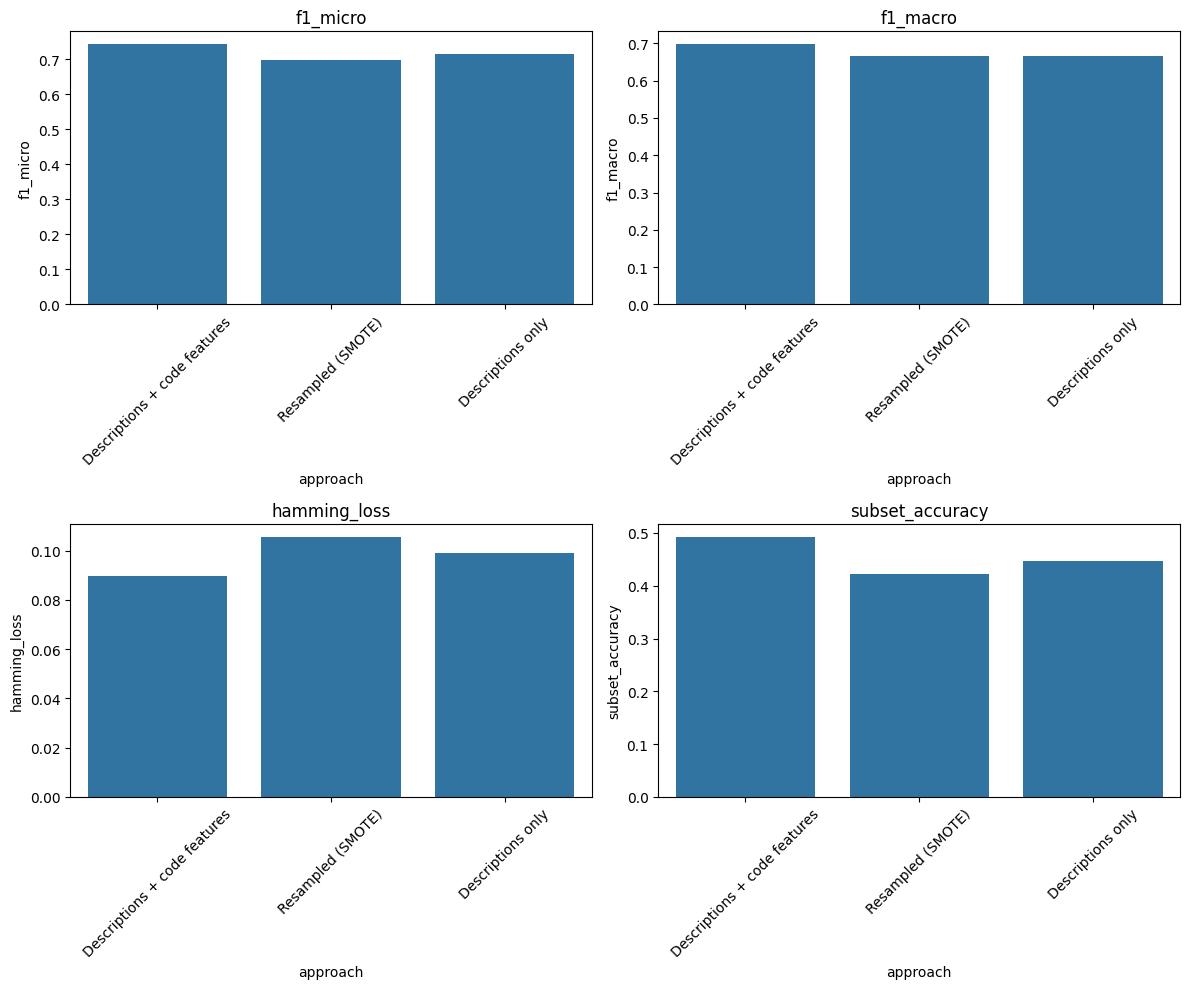

In [68]:
# Visualisation simple
plot_results(results_df)

In [69]:
def plot_confusion_matrices(y_true: pd.DataFrame, y_pred: pd.DataFrame):
    n_labels = len(y_true.columns)
    n_cols = 4  # nombre de colonnes par ligne
    n_rows = int(np.ceil(n_labels / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()  # pour itérer facilement

    for i, label in enumerate(y_true.columns):
        cm = confusion_matrix(y_true[label], y_pred[label])
        cm = cm.astype(float) / cm.sum(axis=1)[:, None]  # normalisation
        sns.heatmap(cm, ax=axes[i], annot=True, fmt=".2f", cmap="Blues")
        axes[i].set_title(f"{label}")

    plt.tight_layout()
    plt.show()



🎯 Meilleur modèle : Descriptions + code features


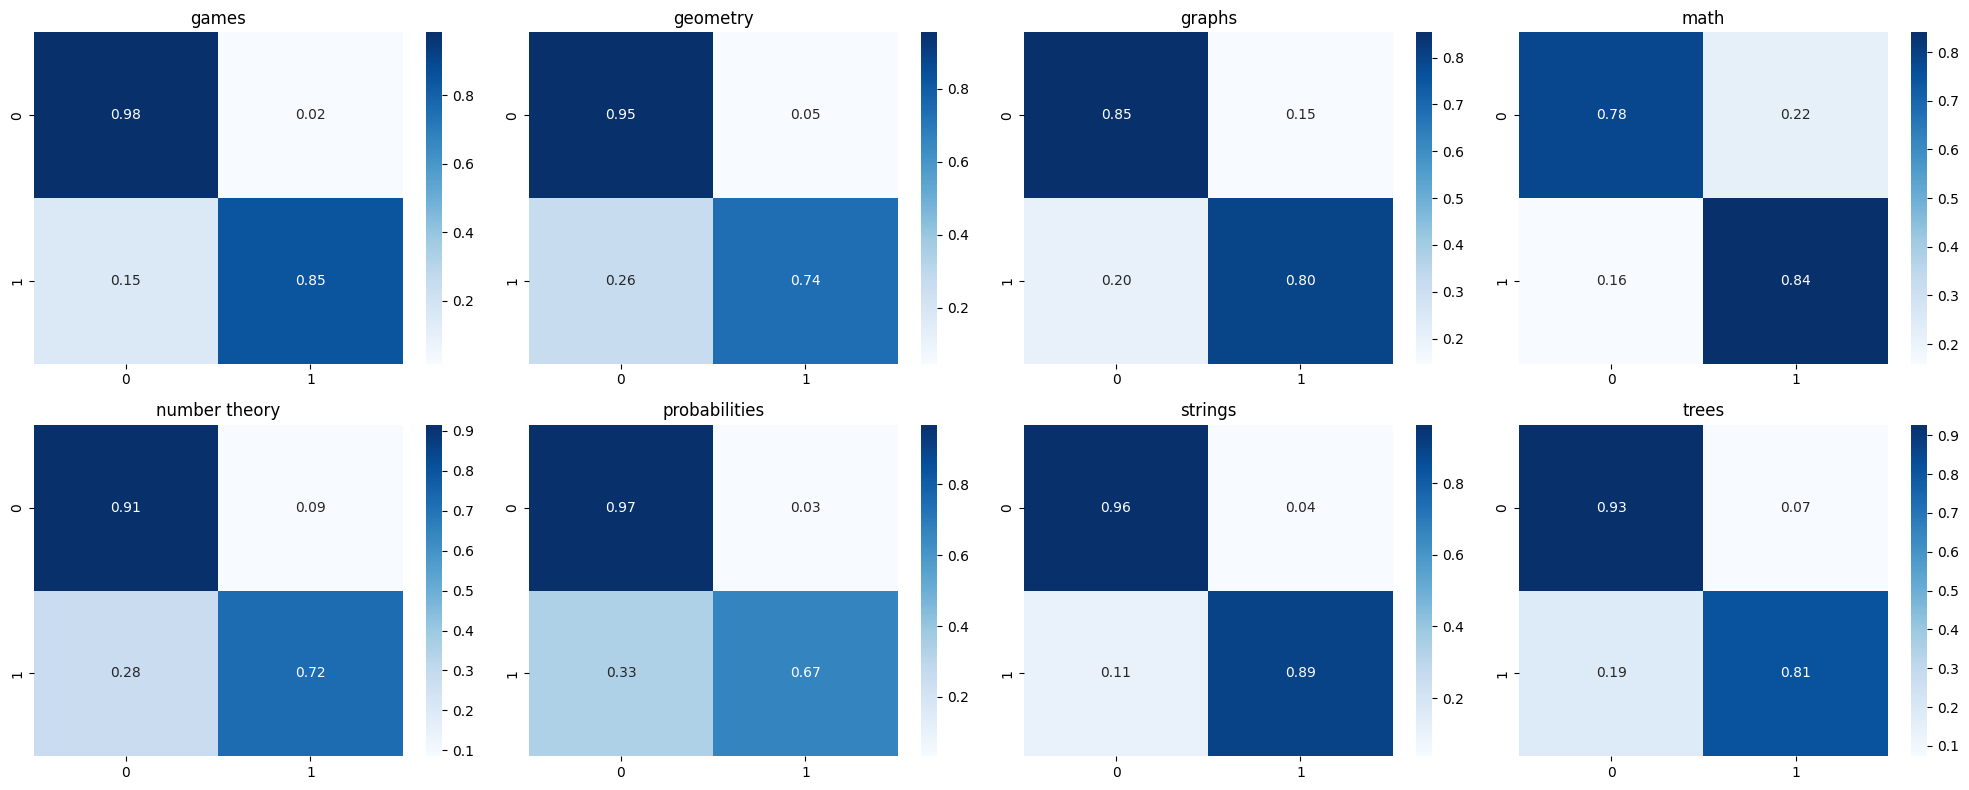

In [70]:
best_approach = results_df["f1_macro"].idxmax()
print(f"\n🎯 Meilleur modèle : {best_approach}")

if best_approach == "Descriptions only":
    y_pred_best = y_pred_desc
elif best_approach == "Descriptions + code features":
    y_pred_best = y_pred_combined
else:
    y_pred_best = y_pred_smote

# Conversion en DataFrame avec noms des tags
y_val_df = pd.DataFrame(y_val, columns=mlb.classes_)

# Plot confusion matrices pour le meilleur modèle
plot_confusion_matrices(y_val_df, pd.DataFrame(y_pred_best, columns=mlb.classes_))


In [71]:
def plot_results(results: pd.DataFrame) -> None:
    n_metrics = len(results.columns)
    n_cols = 2
    n_rows = int(np.ceil(n_metrics / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    axes = axes.flatten()

    for i, metric in enumerate(results.columns):
        sns.barplot(data=results, x=results.index, y=metric, ax=axes[i])
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
        axes[i].set_title(metric)

    # cacher les axes inutilisés
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


In [72]:
def evaluate_label_wise(y_true: pd.DataFrame, y_pred: pd.DataFrame, metrics: dict) -> pd.DataFrame:
    """
    Évalue chaque label/tag séparément selon les métriques fournies.

    Arguments :
        y_true : DataFrame avec les vrais labels
        y_pred : DataFrame avec les prédictions
        metrics : dict {nom_métrique: fonction} pour calculer les métriques

    Retourne :
        DataFrame avec les métriques pour chaque label et une ligne 'Mean'
    """
    results = []

    for label in y_true.columns:
        row = {}
        for metric_name, metric_func in metrics.items():
            row[metric_name] = metric_func(y_true[label], y_pred[label])
        results.append(row)

    results_df = pd.DataFrame(results, index=y_true.columns)
    results_df.loc['Mean'] = results_df.mean(axis=0)

    return results_df


In [73]:
metrics_dict = {
    "F1": lambda y_t, y_p: f1_score(y_t, y_p, zero_division=0),
    "Precision": lambda y_t, y_p: precision_score(y_t, y_p, zero_division=0),
    "Recall": lambda y_t, y_p: recall_score(y_t, y_p, zero_division=0),
    "Accuracy": lambda y_t, y_p: accuracy_score(y_t, y_p)
}


In [74]:
y_pred_best_df = pd.DataFrame(y_pred_best, columns= mlb.classes_)


In [75]:
# Calcul métriques par label
moc_results = evaluate_label_wise(y_val_df, y_pred_best_df, metrics_dict)

print(f"\n🎯 Métriques détaillées par label pour le meilleur modèle ({best_approach}) :")
display(moc_results)


🎯 Métriques détaillées par label pour le meilleur modèle (Descriptions + code features) :


,F1,Precision,Recall,Accuracy
games,0.785714,0.733333,0.846154,0.977612
geometry,0.609756,0.520833,0.735294,0.940299
graphs,0.666667,0.571429,0.800000,0.843284
math,0.821239,0.802768,0.840580,0.811567
number theory,0.651429,0.593750,0.721519,0.886194
probabilities,0.510638,0.413793,0.666667,0.957090
strings,0.853933,0.817204,0.894118,0.951493
trees,0.676056,0.578313,0.813559,0.914179
Mean,0.696929,0.628928,0.789736,0.910215


/tmp/ipython-input-196885636.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/tmp/ipython-input-196885636.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/tmp/ipython-input-196885636.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/tmp/ipython-input-196885636.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)


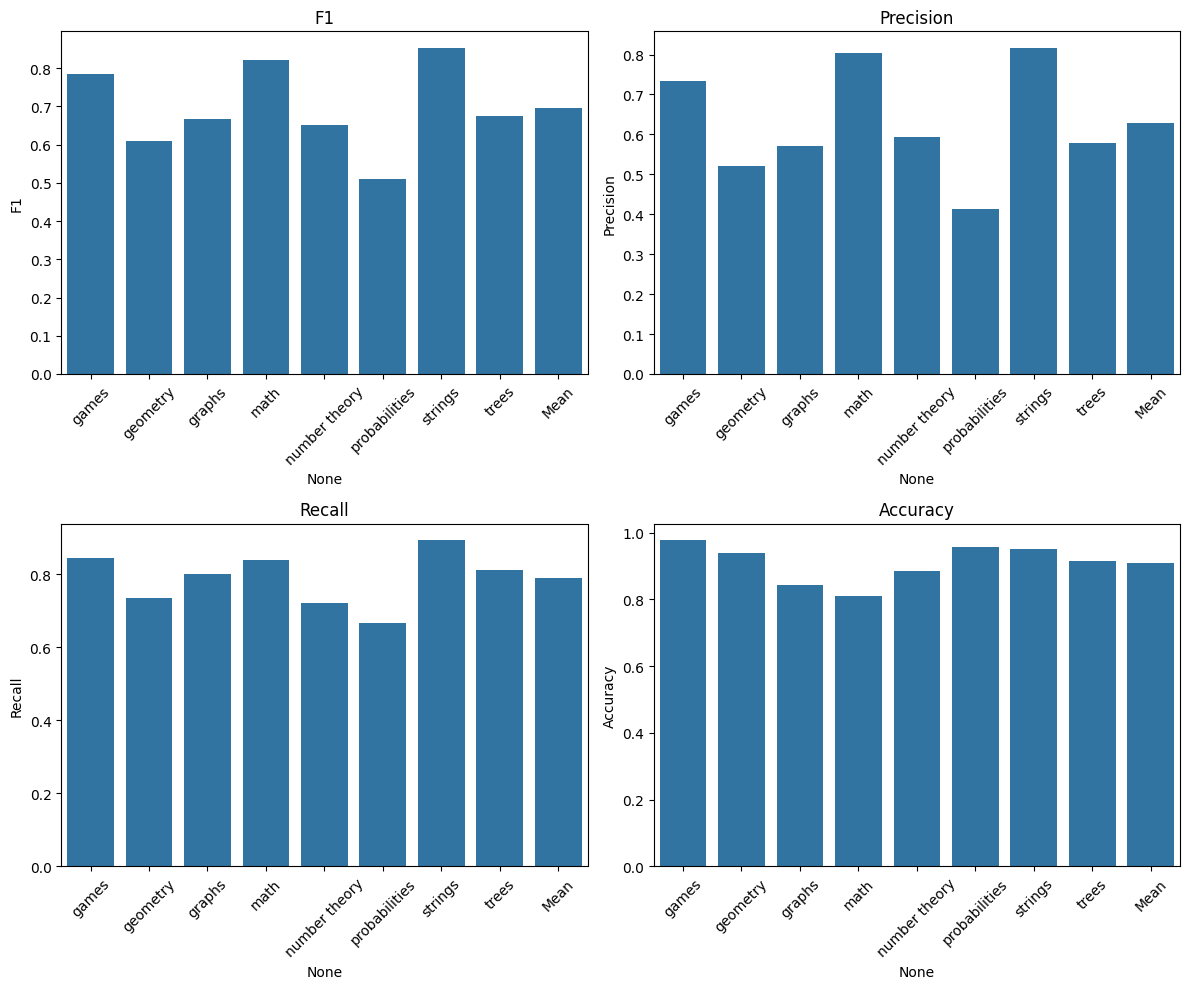

In [76]:
plot_results(moc_results)